In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import itertools
from time import time
import fasttext
from sklearn import preprocessing
from keras.utils import np_utils
from keras.layers import Dense, Embedding, Input, Reshape
from keras.layers import Dropout, MaxPooling1D, Conv1D, Conv2D, Flatten, LSTM, Softmax
from keras.models import Model
from keras.preprocessing import text, sequence
from nn_utils import TrainingHistory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import tensorflow as tf
from datetime import timedelta
from tensorflow.python.layers import base
import tensorflow.contrib.slim as slim
import keras.backend as K
import keras

Using TensorFlow backend.


In [2]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
print(str(list_dir))
nbs = []
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        txt.replace(',', "").replace('.', "").replace('"', "")
        txt.replace("'", "").replace('?', '').replace('!', "")
        txt.replace(':', '').replace(';', '')
        x.append(txt.replace('\n', ' '))
        y.append(repo)
    nbs.append(len(files))
print(str(nbs))
x = np.array(x)
y = np.array(y)

['Advertisement', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
[230, 599, 431, 567, 620, 188, 201, 265, 120, 261]


# Data distribution

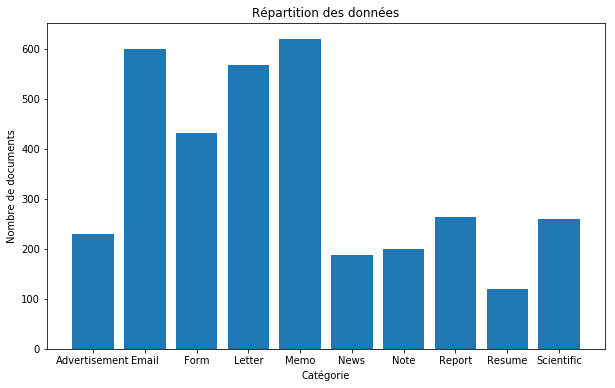

In [3]:
plt.figure(figsize=(10, 6))
plt.title("Répartition des données")
y_pos = np.arange(len(list_dir))
plt.bar(list_dir, nbs, align='center')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de documents')
plt.savefig('repartition_donnees.png')
plt.show()

# Stat of document length

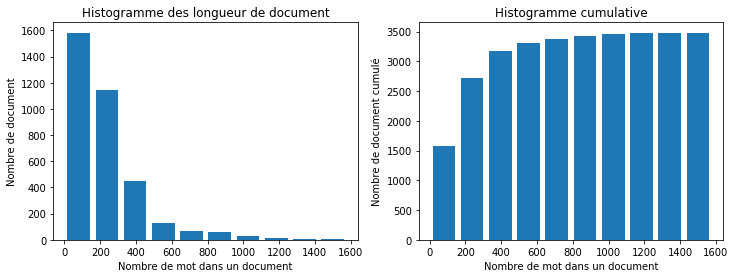

In [4]:
lens = []
for i in range(x.shape[0]):
    line = x[i].split()
    lens.append(len(line))
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Histogramme des longueur de document')
plt.hist(lens, bins=10, rwidth=0.8)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document')
plt.subplot(122)
plt.title('Histogramme cumulative')
plt.hist(lens, rwidth=0.8, cumulative=True)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document cumulé')
plt.savefig('longueur_doc.png')
plt.show()

# Preprocessing of data for FastText classifier and FastText word vector

In [5]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(x, y, test_size=0.2)

In [6]:
with open('tobacco_nolabel.txt', 'w') as f:
    for i in x:
        f.write(i + '\n')

In [8]:
with open('tobacco_train.txt', 'w') as f:
    for i in range(x_train_orig.shape[0]):
        line = x_train_orig[i] + ' __label__' + y_train_orig[i] + '\n'
        f.write(line)
with open('tobacco_test.txt', 'w') as f:
    for i in range(x_test_orig.shape[0]):
        line = x_test_orig[i] + ' __label__' + y_test_orig[i] + '\n'
        f.write(line)

# Example of processed data

In [9]:
y[300]

'Email'

In [10]:
x[300]

"From: Meade, Mary Ann(MAD) on Fri, Jun 28, 1996 9:40 AM Subject: RE: B3G1F Banner stuff  To: Fawcett, Gina  Cc: DeMaio, Laurie  Gina - You or Laurie need to tell me what you want the instruction sht to say. Then we can set the type if you'd like.  VL62Sv6cL02"

# FastText Classification

In [11]:
true_labels = []
pred_labels = []
texts = []
clf = fasttext.supervised('tobacco_train.txt', 'model', epoch=100)
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
pred_labels = [e[0] for e in clf.predict(texts)]


In [48]:
import fastText
train_data = 'tobacco_train.txt'
valid_data = 'tobacco_test.txt'
model = fastText.train_supervised(input=train_data,
                                  epoch=100, 
                                  lr=1.0,
                                  wordNgrams=2,
                                  verbose=2,
                                  minCount=1)
model.test(valid_data)
pred = model.predict(valid_data)

true_labels = []
pred_labels = []
texts = []
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
        pred_labels.append(model.predict(spli[0])[0][0].split('__')[-1])

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


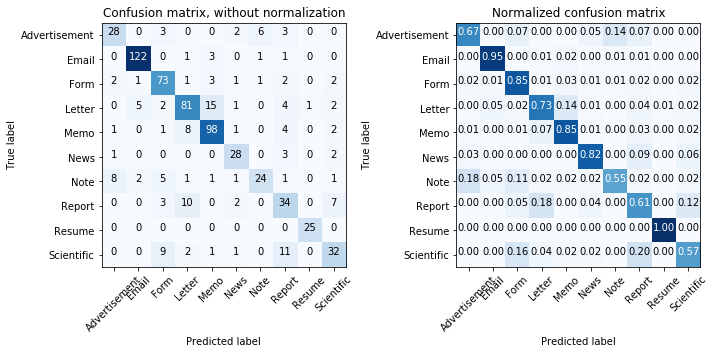

Test Accuracy: 0.7819225251076041
Test F1-score: 0.7819225251076041


In [13]:
class_names = np.unique(true_labels)
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
plt.show()
#print("Test Accuracy:", accuracy_score(true_labels, pred_labels))
print("Test F1-score:", f1_score(true_labels, pred_labels, average="micro"))

# Train word vectors with FastText Skipgram

In [14]:
tic = time()
model_skipgram = fasttext.skipgram('tobacco_nolabel.txt', 
                                   'ft_skipgram_100',
                                   min_count=3,
                                   dim=100,
                                   epoch=50,
                                   thread=16)
toc = time()
print(toc - tic)

38.45707988739014


# Neural network model for text classification

In [15]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of test examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix


def train_fit_predict(model, x_train, x_test, y_train, history):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [159]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    #print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))
    return accuracy_score(y_test, y_predicted)

In [17]:
vectors_file_path = 'ft_skipgram_100.vec'
with open('ft_skipgram_100.vec') as f:
    first_line = f.readline().split()

# CNN-LSTM

In [132]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 80
VALIDATION_SPLIT = 0.2
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

In [20]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train_orig,
                                                                                    x_test_orig,
                                                                                    y_train_orig,
                                                                                    y_test_orig)

Label categories: ['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific']
Converting data to trainable form...
Number of training examples: 2785
Number of test examples: 697


In [139]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    
    #model = Dropout(0.5)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Flatten()(model)
    model = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(model)
    #model = Dense(512, activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 500, 100)          7461600   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 500, 64)           19264     
_________________________________________________________________
dropout_103 (Dropout)        (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 250, 64)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 250, 64)           12352     
_____________________________________________

2228/2228 [==============================] - 3s 1ms/step - loss: 0.6561 - acc: 0.7617 - val_loss: 0.7151 - val_acc: 0.7540
Epoch 49/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.6520 - acc: 0.7644 - val_loss: 0.7148 - val_acc: 0.7594
Epoch 50/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.6362 - acc: 0.7738 - val_loss: 0.6995 - val_acc: 0.7684
Epoch 51/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.6217 - acc: 0.7810 - val_loss: 0.7197 - val_acc: 0.7612
Epoch 52/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.6206 - acc: 0.7801 - val_loss: 0.6957 - val_acc: 0.7738
Epoch 53/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.5959 - acc: 0.7908 - val_loss: 0.6858 - val_acc: 0.7828
Epoch 54/80
2228/2228 [==============================] - 3s 1ms/step - loss: 0.5867 - acc: 0.7944 - val_loss: 0.6854 - val_acc: 0.7774
Epoch 55/80
2228/2228 [==============================] - 3s 1ms/ste

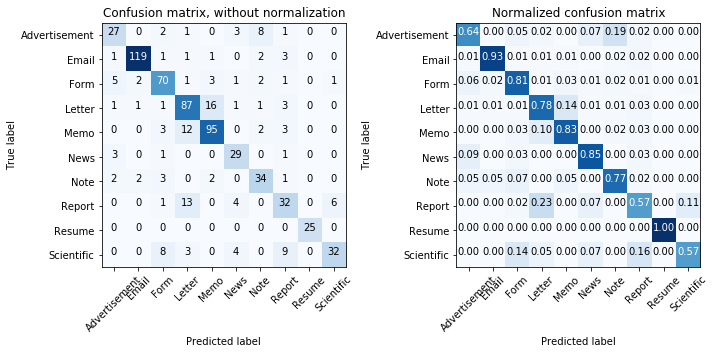

Test Accuracy: 0.7890961262553802
Test F1-score: 0.7890961262553802


0.7890961262553802

In [140]:
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# Pure CNN

In [156]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 500
VALIDATION_SPLIT = 0.2
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 500, 100)          7461600   
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 500, 128)          38528     
_________________________________________________________________
dropout_147 (Dropout)        (None, 500, 128)          0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 250, 128)          0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 250, 64)           24640     
_____________________________________________

2228/2228 [==============================] - 0s 139us/step - loss: 1.3081 - acc: 0.4982 - val_loss: 1.3518 - val_acc: 0.5566
Epoch 46/500
2228/2228 [==============================] - 0s 140us/step - loss: 1.3053 - acc: 0.4987 - val_loss: 1.3180 - val_acc: 0.5871
Epoch 47/500
2228/2228 [==============================] - 0s 139us/step - loss: 1.2853 - acc: 0.4946 - val_loss: 1.3037 - val_acc: 0.5691
Epoch 48/500
2228/2228 [==============================] - 0s 136us/step - loss: 1.2363 - acc: 0.5332 - val_loss: 1.3364 - val_acc: 0.5871
Epoch 49/500
2228/2228 [==============================] - 0s 138us/step - loss: 1.2303 - acc: 0.5211 - val_loss: 1.3340 - val_acc: 0.6176
Epoch 50/500
2228/2228 [==============================] - 0s 139us/step - loss: 1.2163 - acc: 0.5364 - val_loss: 1.2877 - val_acc: 0.6266
Epoch 51/500
2228/2228 [==============================] - 0s 140us/step - loss: 1.2110 - acc: 0.5368 - val_loss: 1.2639 - val_acc: 0.6248
Epoch 52/500
2228/2228 [=======================

2228/2228 [==============================] - 0s 139us/step - loss: 0.7482 - acc: 0.7168 - val_loss: 0.8609 - val_acc: 0.7540
Epoch 105/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.7206 - acc: 0.7253 - val_loss: 0.8571 - val_acc: 0.7415
Epoch 106/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.7222 - acc: 0.7347 - val_loss: 0.8759 - val_acc: 0.7307
Epoch 107/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.7484 - acc: 0.7141 - val_loss: 0.8604 - val_acc: 0.7522
Epoch 108/500
2228/2228 [==============================] - 0s 141us/step - loss: 0.7344 - acc: 0.7213 - val_loss: 0.8401 - val_acc: 0.7469
Epoch 109/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.7110 - acc: 0.7235 - val_loss: 0.8208 - val_acc: 0.7540
Epoch 110/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.6742 - acc: 0.7388 - val_loss: 0.8151 - val_acc: 0.7594
Epoch 111/500
2228/2228 [================

2228/2228 [==============================] - 0s 140us/step - loss: 0.4970 - acc: 0.8173 - val_loss: 0.7689 - val_acc: 0.7792
Epoch 164/500
2228/2228 [==============================] - 0s 137us/step - loss: 0.5188 - acc: 0.8021 - val_loss: 0.7559 - val_acc: 0.7756
Epoch 165/500
2228/2228 [==============================] - 0s 138us/step - loss: 0.5093 - acc: 0.8299 - val_loss: 0.7643 - val_acc: 0.7702
Epoch 166/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.4893 - acc: 0.8294 - val_loss: 0.7399 - val_acc: 0.7774
Epoch 167/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.5015 - acc: 0.8178 - val_loss: 0.7322 - val_acc: 0.7846
Epoch 168/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.4747 - acc: 0.8241 - val_loss: 0.7541 - val_acc: 0.7720
Epoch 169/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.4737 - acc: 0.8245 - val_loss: 0.7438 - val_acc: 0.7774
Epoch 170/500
2228/2228 [================

2228/2228 [==============================] - 0s 142us/step - loss: 0.4175 - acc: 0.8573 - val_loss: 0.7396 - val_acc: 0.7864
Epoch 223/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.4400 - acc: 0.8550 - val_loss: 0.7370 - val_acc: 0.7828
Epoch 224/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3955 - acc: 0.8662 - val_loss: 0.7307 - val_acc: 0.7774
Epoch 225/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.4241 - acc: 0.8505 - val_loss: 0.7224 - val_acc: 0.7738
Epoch 226/500
2228/2228 [==============================] - 0s 138us/step - loss: 0.4001 - acc: 0.8514 - val_loss: 0.7385 - val_acc: 0.7630
Epoch 227/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.4288 - acc: 0.8582 - val_loss: 0.7254 - val_acc: 0.7828
Epoch 228/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.4035 - acc: 0.8600 - val_loss: 0.7333 - val_acc: 0.7810
Epoch 229/500
2228/2228 [================

2228/2228 [==============================] - 0s 139us/step - loss: 0.3381 - acc: 0.8891 - val_loss: 0.7440 - val_acc: 0.7828
Epoch 282/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.3227 - acc: 0.8860 - val_loss: 0.7647 - val_acc: 0.7846
Epoch 283/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3665 - acc: 0.8788 - val_loss: 0.7617 - val_acc: 0.7792
Epoch 284/500
2228/2228 [==============================] - 0s 141us/step - loss: 0.3489 - acc: 0.8900 - val_loss: 0.7649 - val_acc: 0.7702
Epoch 285/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3214 - acc: 0.8891 - val_loss: 0.7861 - val_acc: 0.7899
Epoch 286/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3448 - acc: 0.8797 - val_loss: 0.7703 - val_acc: 0.7882
Epoch 287/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3528 - acc: 0.8752 - val_loss: 0.7891 - val_acc: 0.7720
Epoch 288/500
2228/2228 [================

2228/2228 [==============================] - 0s 141us/step - loss: 0.3369 - acc: 0.8896 - val_loss: 0.7677 - val_acc: 0.7810
Epoch 341/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.3132 - acc: 0.8900 - val_loss: 0.8051 - val_acc: 0.7864
Epoch 342/500
2228/2228 [==============================] - 0s 137us/step - loss: 0.3196 - acc: 0.8959 - val_loss: 0.7804 - val_acc: 0.7774
Epoch 343/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.2904 - acc: 0.9017 - val_loss: 0.7605 - val_acc: 0.7792
Epoch 344/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.3070 - acc: 0.8963 - val_loss: 0.8077 - val_acc: 0.7810
Epoch 345/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.2892 - acc: 0.9031 - val_loss: 0.7619 - val_acc: 0.7882
Epoch 346/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3073 - acc: 0.9008 - val_loss: 0.7874 - val_acc: 0.7720
Epoch 347/500
2228/2228 [================

2228/2228 [==============================] - 0s 140us/step - loss: 0.2638 - acc: 0.9084 - val_loss: 0.7986 - val_acc: 0.7864
Epoch 400/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.2814 - acc: 0.9044 - val_loss: 0.8154 - val_acc: 0.7846
Epoch 401/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3011 - acc: 0.9066 - val_loss: 0.8203 - val_acc: 0.7756
Epoch 402/500
2228/2228 [==============================] - 0s 141us/step - loss: 0.3073 - acc: 0.9017 - val_loss: 0.8101 - val_acc: 0.7864
Epoch 403/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.3011 - acc: 0.9062 - val_loss: 0.8117 - val_acc: 0.7756
Epoch 404/500
2228/2228 [==============================] - 0s 141us/step - loss: 0.2690 - acc: 0.9026 - val_loss: 0.8591 - val_acc: 0.7792
Epoch 405/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.3214 - acc: 0.9017 - val_loss: 0.8133 - val_acc: 0.7792
Epoch 406/500
2228/2228 [================

2228/2228 [==============================] - 0s 137us/step - loss: 0.2975 - acc: 0.9102 - val_loss: 0.8504 - val_acc: 0.7738
Epoch 459/500
2228/2228 [==============================] - 0s 141us/step - loss: 0.2743 - acc: 0.9174 - val_loss: 0.8343 - val_acc: 0.7792
Epoch 460/500
2228/2228 [==============================] - 0s 139us/step - loss: 0.2921 - acc: 0.9080 - val_loss: 0.8653 - val_acc: 0.7738
Epoch 461/500
2228/2228 [==============================] - 0s 138us/step - loss: 0.2623 - acc: 0.9156 - val_loss: 0.8372 - val_acc: 0.7810
Epoch 462/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.2776 - acc: 0.9134 - val_loss: 0.8783 - val_acc: 0.7720
Epoch 463/500
2228/2228 [==============================] - 0s 140us/step - loss: 0.2720 - acc: 0.9156 - val_loss: 0.8076 - val_acc: 0.7756
Epoch 464/500
2228/2228 [==============================] - 0s 138us/step - loss: 0.2511 - acc: 0.9165 - val_loss: 0.8226 - val_acc: 0.7774
Epoch 465/500
2228/2228 [================

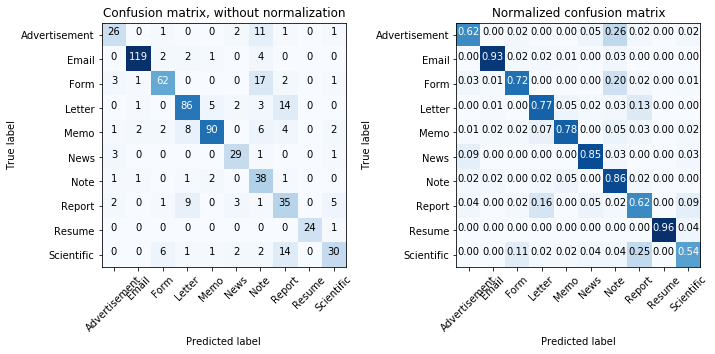

Test Accuracy: 0.7733142037302726
Test F1-score: 0.7733142037302725


0.7733142037302726

In [158]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)

    model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.8)(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.8)(model)
    #model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.9)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# TF-IDF

In [31]:
TF_IDF_FEATURES = 2000
# Create document vectors
vectorizer = CountVectorizer(max_features=TF_IDF_FEATURES)
vectorizer.fit(x_train_orig)
x_train_counts = vectorizer.transform(x_train_orig)
x_test_counts = vectorizer.transform(x_test_orig)

# With TF-IDF representation
tf_transformer = TfidfTransformer()
tfidf = tf_transformer.fit(x_train_counts)
x_train_tf = tfidf.transform(x_train_counts)
x_test_tf = tfidf.transform(x_test_counts)

# Neural Network with TF-IDF

In [124]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,))
    model = Dense(1024, activation='relu')(inp)
    model = Dropout(0.8)(model)
    #model = Dense(256, activation="relu")(model)
    #model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def class_str_2_ind_label(y_train, y_test):
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    test_y_cat = np_utils.to_categorical(y_test, n_out)
    
    return y_train, y_test, train_y_cat, test_y_cat


In [128]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
#MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 30
VALIDATION_SPLIT = 0.2
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 2000)              0         
_________________________________________________________________
dense_144 (Dense)            (None, 1024)              2049024   
_________________________________________________________________
dropout_95 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_145 (Dense)            (None, 10)                10250     
Total params: 2,059,274
Trainable params: 2,059,274
Non-trainable params: 0
_________________________________________________________________
Train on 2228 samples, validate on 557 samples
Epoch 1/30
2228/2228 [==============================] - 2s 1ms/step - loss: 2.1746 - acc: 0.3021 - val_loss: 1.9592 - val_acc: 0.4740
Epoch 2/30
2228/2228 [==============================] - 0s 55us/step - loss: 1.8040

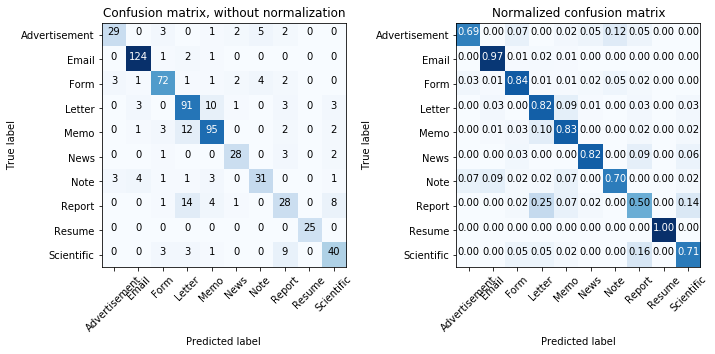

Test Accuracy: 0.8077474892395983
Test F1-score: 0.8077474892395983


In [131]:
y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train_orig, y_test_orig)
model = get_model()
history = TrainingHistory(x_test_tf, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf, x_test_tf, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
#print("Test Accuracy:", accuracy_score(y_test, y_predicted))
print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))


# Self-attention model with TF-IDF

[Code](https://github.com/CyberZHG/keras-self-attention)

In [53]:
x_train_tf_dense = x_train_tf.toarray()
x_train_tf_dense = np.reshape(x_train_tf_dense, (x_train_tf_dense.shape[0], x_train_tf_dense.shape[1], 1))
x_test_tf_dense = x_test_tf.toarray()
x_test_tf_dense = np.reshape(x_test_tf_dense, (x_test_tf_dense.shape[0], x_test_tf_dense.shape[1], 1))

In [55]:
class ScaledDotProductAttention(keras.layers.Layer):
    
    def __init__(self,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        #self.supports_masking = True
        #self.return_attention = return_attention
        #self.history_only = history_only
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        
    def call(self, inputs, squeeze=False, mask=None, **kwargs):
        query = inputs
        key = inputs
        value = inputs
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        """
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            ones = tf.ones((query_len, key_len))
            e -= (ones - tf.matrix_band_part(ones, -1, 0)) * 1e9
        if isinstance(mask, list) and mask[-1] is not None:
            e -= (1.0 - K.cast(K.expand_dims(mask[-1], axis=-2), K.floatx())) * 1e9
        """
        a = keras.activations.softmax(e)
        v = K.batch_dot(a, value)
        #if squeeze:
        #    v = K.squeeze(v, axis=2)
        #if self.return_attention:
        #    return [v, a]
        print(v.shape)
        return v


In [56]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,1))
    model = ScaledDotProductAttention()(inp)
    model = Reshape((TF_IDF_FEATURES,))(model)
    #model = Flatten()(model)
    #model = Dense(TF_IDF_FEATURES, activation='relu', input_shape=(TF_IDF_FEATURES,))(model)
    #model = Dropout(0)(model)
    model = Dense(128, activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = Flatten()(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


In [59]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

(?, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2000, 1)           0         
_________________________________________________________________
scaled_dot_product_attention (None, 2000, 1)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 2000)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               256128    
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
Total params: 257,418
Trainable params: 257,418
Non-trainable params: 0
_________________________________________________________________
Train on 2506 samples, validate on 279 samples
Epoch 1/10
2506/2506 [==============================] - 3s 1ms/step - loss: 

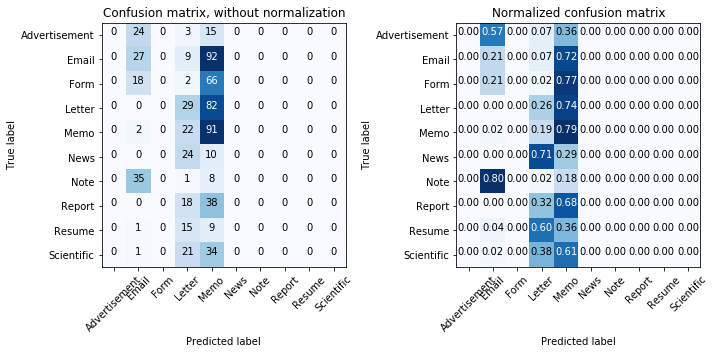

Test Accuracy: 0.2109038737446198
Test F1-score: 0.2109038737446198


In [60]:
#y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train, y_test)
model = get_model()
history = TrainingHistory(x_test_tf_dense, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf_dense, x_test_tf_dense, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
#print("Test Accuracy:", accuracy_score(y_test, y_predicted))
print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))

# Manually self attention

In [161]:
mat = x_train_tf_dense[:,:,0]
atts = np.empty(mat.shape)
for i in range(mat.shape[0]):
    q = np.array(mat[i, :]).reshape((2000, 1))
    k = np.array(mat[i, :]).reshape((2000, 1))
    single = np.dot(q, k.T)
    ps = np.empty(single.shape)
    for j in range(single.shape[0]):
        ps[j,:]  = np.exp(single[j,:])
        ps[j,:] /= np.sum(ps[j,:])
    att = np.dot(ps, k)
    atts[i, :] = att.T

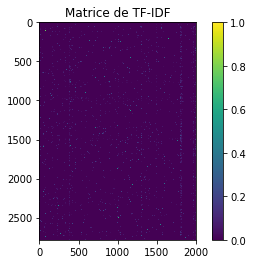

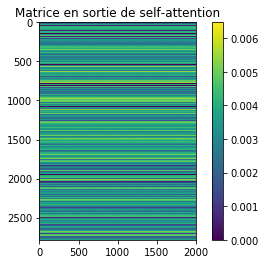

In [162]:
plt.figure()
plt.title("Matrice de TF-IDF")
plt.imshow(mat)
plt.colorbar()
plt.savefig('tf_idf.png')
plt.figure()
plt.title('Matrice en sortie de self-attention')
plt.imshow(atts)
plt.colorbar()
plt.savefig('self_att.png')

# Self-attention with embedding

In [82]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.2
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

Converting data to trainable form...
Number of training examples: 2785
Number of test examples: 697
Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
(?, 500, 100)
(?, 500, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 500, 100)          7461600   
_________________________________________________________________
scaled_dot_product_attention (None, 500, 100)          0         
_________________________________________________________________
dense_107 (Dense)            (None, 500, 128)          12928     
_________________________________________________________________
dropout_76 (Dropout)         (None, 500, 128)          0         
_________________________________________________

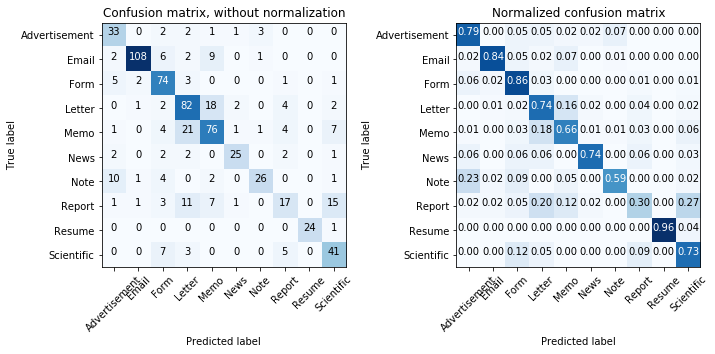

Test Accuracy: 0.7259684361549498
Test F1-score: 0.7259684361549498


0.7259684361549498

In [92]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    model = ScaledDotProductAttention()(model)
    #model = Conv1D(filters=32, kernel_size=1, padding='same', activation='relu')(model)
    model = Dense(128, activation='relu')(model)
    model = Dropout(0.8)(model)
    model = ScaledDotProductAttention()(model)
    model = Dense(128, activation='relu')(model)
    model = Dropout(0.8)(model)
    #model = ScaledDotProductAttention()(model)
    #model = Dense(64, activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = Flatten()(model)
    
    #model = Dense(128, activation='relu')(model)
    #model = Dropout(0.8)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train_orig,
                                                                                    x_test_orig,
                                                                                    y_train_orig,
                                                                                    y_test_orig)
evaluation(vectors_file_path, print_sum=True, plot_mat=True)